# Bioremediation of a Coastal Oil Spill: A Case Study Using a Community Genome-Scale Metabolic Model

<img src="https://github.com/Robaina/Robaina/assets/21340147/620a2958-48b3-4b01-8614-4b67c33c167b" alt="Banner image depicting bioremediation" style="width:100%; max-height:200px;">

Oil spills are among the most devastating environmental disasters, posing significant threats to marine ecosystems. In the aftermath of such spills, there is typically a [surge in microbial communities](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) capable of degrading hydrocarbons found in oil. These communities form complex trophic networks, with different species playing specific roles in the degradation process. By understanding and harnessing the potential of these communities, we can develop effective bioremediation strategies to mitigate the impact of oil spills. Specifically, community metabolic models can be employed to investigate key species and trophic relationships essential for the degradation process. With this knowledge, we can engineer microbial communities, designing [bioaugmentation](https://en.wikipedia.org/wiki/Bioaugmentation) or [biostimulation](https://en.wikipedia.org/wiki/Biostimulation) strategies to enhance bioremediation potential.

In this Jupyter Notebook, we will utilize a community genome-scale metabolic model to explore the trophic network that emerges following a marine coastal oil spill. We will also apply constraint-based modeling techniques, such as [Flux Balance Analysis (FBA)](https://en.wikipedia.org/wiki/Flux_balance_analysis) to identify key taxa and environmental nutrients that could improve the degradation of toxic compounds. Finally, we will develop a biostimulation strategy by adding specific nutrients to the medium, aiming to enhance the bioremediation potential of the community.

__NOTES__:  

* The results presented in this Notebook are meant to be illustrative and do not represent a real-world scenario, which would require an exhaustive analysis as well as experimental validation.

__INSTALLATION__:

* To run this Notebook, clone this [GitHub repository](https://github.com/Robaina/oil_spill_example) and follow instructions therein.

## The Community and the Environment

The community under study consists of five bacterial genera, which are [known to be involved](https://www.frontiersin.org/articles/10.3389/fmicb.2021.633659/full) in the degradation of toluene. The involved genera include:

- *Alcanivorax*
- *Polaribacter*
- *Pseudomonas*
- *Rhodococcus*
- *Thalassospira*

Our model will simulate a marine medium with three representative carbon sources commonly found in surface waters:

- *Glycogen*, the main storage polymer in cyanobacteria and up to [100 times more abundant](https://ami-journals.onlinelibrary.wiley.com/doi/full/10.1111/1462-2920.14302) than other phytoplankton exudates, such as free monosaccharides or amino acids.
- *Glycinebetaine*, which is [highly abundant](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9321204/) in marine environments.
- *D-Xylulose*, representing the degradation of microalgal polysaccharides.

Additionally, we will include *Toluene*, one of the [most abundant and toxic components](https://www.researchsquare.com/article/rs-3200599/v1) in crude oil, as a representative compound from the oil spill.

## Relevant Tools

For our analysis, we will use the following tools:

* [MICOM](https://github.com/micom-dev/micom): a computational tool for constructing and analyzing community genome-scale metabolic models. It integrates individual metabolic models representing different bacterial genera into a unified community model, enabling the study of metabolic interactions within microbial communities.

* [Cobrapy](https://github.com/opencobra/cobrapy): a Python library for genome-scale metabolic modeling. It offers a straightforward interface for creating, manipulating, and simulating biological networks, essential in systems biology, bioinformatics, and computational biology. Cobrapy is used under the hood by MICOM.

* [NetworkX](https://github.com/networkx): a Python library designed for the creation, manipulation, and analysis of the structure, dynamics, and functions of complex networks. It provides data structures for graphs, graph algorithms, generators, and drawing tools, widely used in various fields such as bioinformatics, social network analysis, and transportation networks.


## Building the Community Model

To construct a community genome-scale model, our first step is to acquire individual genome-scale metabolic models (GEMs) for each bacterial genus within our community. These will then be combined into a unified community model. For this purpose, we will use GEMs from the [MICOM's model database](https://zenodo.org/records/3755182). These GEMs were reconstructed utilizing [CarveMe](https://academic.oup.com/bioinformatics/article/34/17/3038/4999126), a tool designed to reconstruct GEMs from genomes using a universal metabolic model. The representative prokaryotic genomes for each genus were sourced from RefSeq. For your convenience, the individual GEMs used in this notebook are located in the `models` directory.

__NOTE__: In a real-world scenario, it would be possible to reconstruct GEMs directly from metagenome-assembled genomes (MAGs) isolated from the oil spill site.

To construct the community model, we will integrate these individual GEMs into a larger, unified model. This comprehensive model will include a space for shared extracellular metabolites and a community biomass pseudoreaction, in addition to the individual biomass reactions present in each GEM. For this integration, we will use the `build` workflow provided by the Micom toolbox.

MICOM requires a configuration file to execute the `build` workflow. This file specifies the ID and path for each individual GEM. Additionally, MICOM needs a measure of the relative abundance of each community member, as flux predictions for each member are scaled according to their relative abundances, ensuring coherent fluxes across the community. In our study, we will assume equal abundances for all genera. It's worth noting that MICOM also allows for the adjustment of relative abundances post model construction. The configuration file for this notebook can be found in `data/micom_database.tsv`.

In [5]:
import pandas as pd

taxo_df = pd.read_csv("data/micom_database_minimal.csv", sep=",", index_col=None)
taxo_df

,sample_id,id,abundance,file
0,oilspill,Pseudomonas,100,models/Pseudomonas.json
1,oilspill,Rhodococcus,100,models/Rhodococcus.json
2,oilspill,Thalassospira,100,models/Thalassospira.json
3,oilspill,Polaribacter,100,models/Polaribacter.json
4,oilspill,Alcanivorax,100,models/Alcanivorax.json


Let's begin by assembling our community model! The `build` pipeline in Micom will generate a community model, which is saved as a pickle file. This file encapsulates the entire community model, facilitating subsequent analytical processes.

For those who wish to skip the model building phase and dive straight into analysis, we have provided a pre-built community model. You can find this ready-to-use model in the `data` folder, also saved as a pickle file.

In [2]:
%%capture
from micom.workflows import build

manifest = build(taxonomy=taxo_df, model_db=None, out_folder="results/micom", cutoff=1e-2, threads=14 , solver="hybrid")

Now, let's take a closer look at the community model we have just constructed. As illustrated below, the model integrates all five individual genome-scale metabolic models (GEMs). It encompasses an impressive aggregate of over 12500 reactions and more than 6300 metabolites. Furthermore, MICOM has formulated a community-wide biomass reaction, which serves as the default optimization objective (termed `community_objective`).

In [1]:
from micom import load_pickle

cgem = load_pickle("results/micom/oilspill.pickle")
cgem

Name,oilspill
Memory address,7f9c7b17b3d0
Number of metabolites,7944
Number of reactions,12564
Number of genes,6386
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"C_c__Pseudomonas, C_p__Pseudomonas, C_e__Pseudomonas, m, C_c__Rhodococcus, C_p__Rhodococcus, C_e__Rhodococcus, C_c__Thalassospira, C_p__Thalassospira, C_e__Thalassospira, C_c__Polaribacter, C_p__Polaribacter, C_e__Polaribacter, C_c__Alcanivorax, C_e__Alcanivorax, C_p__Alcanivorax"


## Preparing the Medium for the Simulation

We will now prepare the medium used for simulating the oil spill scenario. Specifically, we're employing a marine medium, which includes various salts and essential cofactors like thiamin. As previously mentioned, this medium incorporates three carbon sources typically found in surface waters, along with toluene, representing a common compound in oil spills.

The composition of the medium is detailed in `data/oilspill_medium.tsv`. This file is structured into two columns: the first lists the reaction IDs associated with the exchange reactions in the community model that allow the uptake of specific compounds from the medium. The second column indicates the maximum allowed uptake rate for each compound, measured in mmol/gDW/h. It's important to note that while maximum flux values are positive in this file, the convention in constraint-based modeling is to use negative values for uptake reactions. However, MICOM (and Cobrapy, which it utilizes) automatically adjusts for this convention.

In [3]:
import pandas as pd

medium = pd.read_csv('data/oilspill_medium.tsv', sep='\t', header=None)
medium.columns = ["reaction", "flux"]
medium.set_index('reaction', inplace=False)
medium = medium[medium.reaction.isin([r.id for r in cgem.exchanges])]

## Optimizing Community Growth

With the growth medium established, we're now set to initiate our first simulation. We'll start by maximizing community growth using standard Flux Balance Analysis (FBA). Although optimizing growth is not the primary focus of this Notebook, and isn't required for our analysis, we'll proceed with this step to verify that the model is functioning as expected.

In [3]:
cgem.medium = medium.set_index('reaction').squeeze()
sol = cgem.optimize()
sol

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alcanivorax,0.2,0.000000,2005,1329
Polaribacter,0.2,0.154912,1973,1311
Pseudomonas,0.2,2.028664,3277,1869
Rhodococcus,0.2,0.000000,2639,1548
Thalassospira,0.2,0.005049,2282,1499
medium,NaN,NaN,388,388


As demonstrated above, the community achieves a maximum growth rate of $0.438 \, h^{-1}$ in this medium. However, it's notable that not all members exhibit positive individual growth rates in the simulation. This outcome stems from using regular FBA, which focuses solely on maximizing the community biomass reaction, disregarding individual growth rates. To remedy this, MICOM offers the cooperative tradeoff algorithm. This approach simultaneously optimizes community and individual growth rates by applying a tradeoff parameter between the two objectives. For comparison purposes, we will employ a tradeoff value of $0.5$.

In [14]:
cgem.medium = medium.set_index('reaction').squeeze()
sol_coop = cgem.cooperative_tradeoff(fraction=0.5, fluxes=True)
sol_coop

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alcanivorax,0.2,0.272336,2005,1329
Polaribacter,0.2,0.272319,1973,1311
Pseudomonas,0.2,0.272336,3277,1869
Rhodococcus,0.2,0.272332,2639,1548
Thalassospira,0.2,0.005040,2282,1499
medium,NaN,NaN,388,388


After running the `cooperative_tradeoff` algorithm, we see that all members have now positive growth rates. However, the community growth rate has decreased to $0.219 \;h^{-1}$. This is expected, because the algorithm is now optimizing both community and individual growth rates, which are competing objectives. In this case, the algorithm has found a tradeoff between the two objectives, which results in a suboptimal, and likely more realistic, community growth rate.

Now that we have checkek that the model is working as expected, let's move on to the analysis of the trophic network.

## Analyzing Trophic Interactions Among Community Members

Our next step is to delve into the metabolic interactions between the various species within our community model. For this purpose, we will utilize MICOM's `grow` workflow. This workflow simulates the growth of the community on different carbon sources in our specified medium, including the pollutant toluene. It employs the cooperative growth algorithm, the same we discussed earlier, with a tradeoff parameter between community and individual growth rates set at $0.5$. The output from this workflow will be a dataframe that details the fluxes through all exchange reactions, thereby sharing metabolites among community members. We will analyze these results to map out the network of trophic interactions within the community, aiming to identify the genera that are directly involved in the uptake and degradation of toluene.

For efficiency, you may choose to bypass the upcoming simulation cell and instead use the pre-computed results available in `results/micom/exchanges.tsv`.

In [7]:
from micom.workflows import grow

res = grow(manifest, model_folder="results/micom/", medium=medium, tradeoff=0.5, threads=14, atol=1.1e-6)
res.exchanges[res.exchanges.taxon != 'medium'].to_csv("results/micom/exchanges.tsv", sep="\t")

Output()

In [4]:
import pandas as pd

exchanges_df = pd.read_csv("results/micom/exchanges.tsv", sep="\t", index_col=0)
exchanges_df.head()

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
388,Alcanivorax,oilspill,0.000001,EX_for_e,0.326440,0.2,for_e,export
391,Alcanivorax,oilspill,0.000001,EX_glu__L_e,-0.166111,0.2,glu__L_e,import
398,Alcanivorax,oilspill,0.000001,EX_gly_e,-100.000000,0.2,gly_e,import
399,Alcanivorax,oilspill,0.000001,EX_etoh_e,-46.968683,0.2,etoh_e,import
400,Alcanivorax,oilspill,0.000001,EX_skm_e,-0.051829,0.2,skm_e,import


The results we have obtained clearly indicate the presence of trophic interactions among the community members. The table presented above enumerates the compounds being exchanged within the community. In the `reaction` field, each entry corresponds to an exchange reaction that either imports a compound from or exports it to the medium. The `flux` field indicates the direction of this exchange, with negative values representing import and positive values representing export. Additionally, the `taxon` field identifies which community member is responsible for importing or exporting each compound.

It's important to note that this table includes all compounds present in the medium. This encompasses not only the original compounds that served as starting points for community growth but also new compounds synthesized and excreted by the community members.

By examining the table, we can figure out which community members are able to uptake `toluene` from the enviroment. Specifically, reaction `EX_tol_e` should display a negative flux value, since negative flux values denote imports:

In [5]:
toluene_uptakers = exchanges_df[(exchanges_df['reaction'] == 'EX_tol_e') & (exchanges_df['flux'] < 0)]
toluene_uptakers

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
767,Pseudomonas,oilspill,0.000001,EX_tol_e,-0.000079,0.2,tol_e,import


According to the results above, `Pseudomonas` is the only member able to uptake toluene from the environment. Let's next visualize the trophic relations with a network graph

### Representing the Trophic Network as a Bipartite Graph

To facilitate our analysis, we will now represent these trophic relationships in the form of a bipartite graph. In this graph, the nodes are designated either as compounds or community members, while the edges symbolize the trophic interactions between them. We'll employ the `networkx` library to both construct and visualize this graph. For the sake of simplicity in our visualization, we will focus on a selected subset of taxa as well as a subset of all excreted compounds, excluding most inorganic compounds. However, note that this is just for the visualization, the full set of taxa and compounds is used throughout the analysis in this notebook. You may change the selected taxa to dsiplay in the graph by updating the `selected_taxa` variable in the cell below.

In [6]:
from src.helper_functions import (
    generate_bipartite_graph,
    get_donor_receiver_from_exchanges,
    get_used_medium_sources
    )

selected_taxa = taxo_df.id.to_list()

hidden_metabolites = [
    'h', 'h2', 'btn', 'ca2', 'cl', 'co2',
    'cu2', 'fe2', 'fe3', 'k', 'no2', 'no3',
    'so4', 'thm', 'zn2', 'pi', 'h2o', 'o2',
    'cobalt2', 'nh4', 'hco3', 'mg2', 'mn2'
    ]

# Prepare bipartite graph
donor_receiver_df = get_donor_receiver_from_exchanges(exchanges_df)
donor_receiver_df.loc[:, "compound"] = donor_receiver_df[
    "compound"
    ].str.replace("glycogen1500_m", "glycog_m") # Simplify glycogen ID
used_medium_sources = get_used_medium_sources(donor_receiver_df)

exchanges_file_path = "results/micom/exchanges.tsv"
all_taxa = taxo_df["id"].tolist()
hidden_taxa = [taxon for taxon in all_taxa if taxon not in selected_taxa]

bipartite_graph = generate_bipartite_graph(
    exchanges_file_path,
    hide_taxa=hidden_taxa,
    hide_metabolites=hidden_metabolites,
    keep_metabolites=["bz"],
    flux_cutoff=0.0,
    target_taxon="Pseudomonas",
    environmental_carbon_sources=used_medium_sources,
    relabel_nodes={"glycogen1500": "glycog"},
    output_graph="results/micom/bipartite_graph.json",
    )

### Plotting the Trophic Network

Our final step involves using `networkx` to plot the bipartite graph we previously generated. For this visualization, we'll adopt a shell layout, where the two classes of nodes – compounds and taxa – are arranged in two concentric circles. The nodes representing compounds will be positioned on the external circle, while those representing taxa will be located on the internal circle. This arrangement is chosen to enhance the visibility and clarity of the edges connecting the nodes.

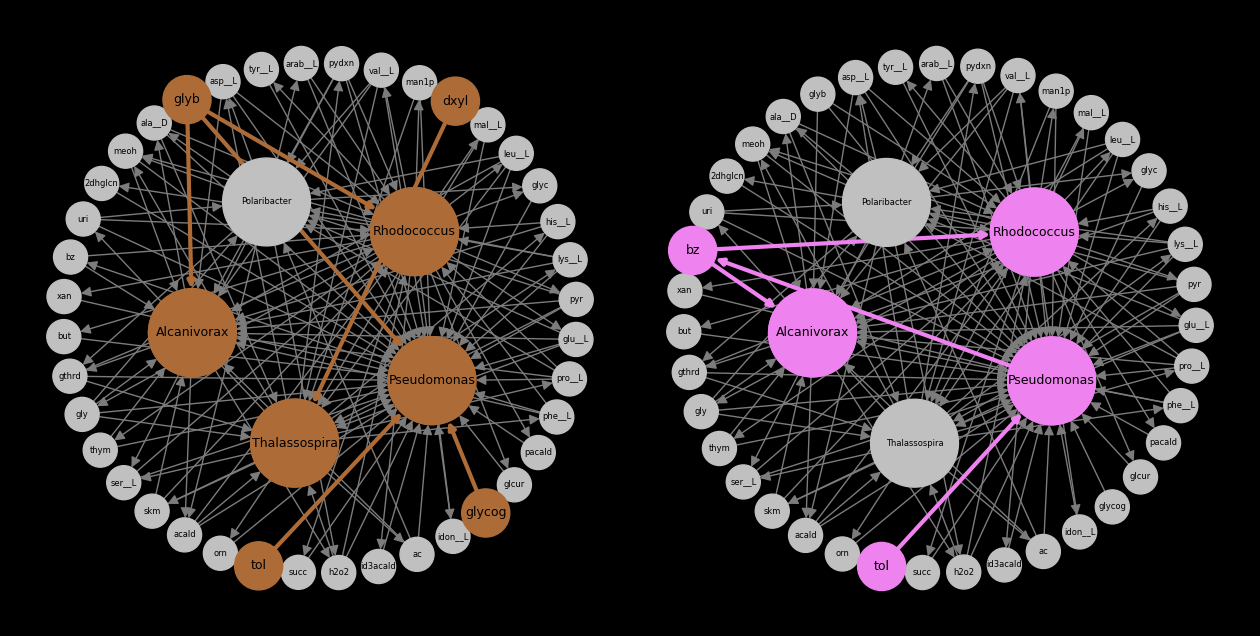

In [8]:
from matplotlib import pyplot as plt
from src.helper_functions import plot_trophic_interactions

environmental_carbon_sources = used_medium_sources
color_other_edges = '#7c7c7c'
color_other_nodes = 'silver'
target_taxon = 'Pseudomonas'
large_node_size = 4000
small_node_size = 600
edge_width_target_taxon = 3.0
edge_width_other = 1.0
arrow_size_target_taxon = 10
arrow_size_other = 15
font_size = 6
seed = 2

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[0],
    highlight_compounds=["glycog", "dxyl", "glyb", "tol"],
    target_taxon=target_taxon,
    color_oil_nodes='#ad6c37',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)
plot_trophic_interactions(
    bipartite_graph=bipartite_graph,
    environmental_carbon_sources=environmental_carbon_sources,
    ax=axs[1],
    highlight_compounds=["tol", "bz"],
    target_taxon=target_taxon,
    color_oil_nodes='violet',
    color_other_edges=color_other_edges,
    color_other_nodes=color_other_nodes,
    large_node_size=large_node_size,
    small_node_size=small_node_size,
    edge_width_target_taxon=edge_width_target_taxon,
    edge_width_other=edge_width_other,
    arrow_size_target_taxon=arrow_size_target_taxon,
    arrow_size_other=arrow_size_other,
    font_size=font_size,
    seed=seed
)

fig.set_facecolor("black")
plt.subplots_adjust(wspace=0, hspace=0) 
plt.show()

The figures above reveal a complex trophic network in our community model. The first graph shows the processing of external carbon sources (colored brown: Glycogen, D-Xylulose, Glycinebetaine, and Toluene). The community also generates and exchanges a variety of organic compounds (gray nodes), crucial for collective growth and aiding in toluene degradation.

The second graph focuses on Toluene degradation. _Pseudomonas_ consumes Toluene, converting it into Benzoate, which is then further degraded into non-toxic substances by _Alcanivorax_ and _Rhodococcus_. _Thalassospira_ and _Polaribacter_, while not directly involved in Toluene degradation, support the process by producing compounds which are utilized by _Pseudomonas_ for its growth.

For a detailed look at specific interactions, we can examine the exchanges involving _Pseudomonas_. A specialized function filters the original exchanges dataframe to highlight these interactions, offering insights into the compounds imported by _Pseudomonas_ and the community members supporting its growth.

In [9]:
from src.helper_functions import get_shared_metabolites_for_taxon

pseudomonas_imports = get_shared_metabolites_for_taxon(exchanges_df, 'Pseudomonas')
pseudomonas_imports.to_csv('results/micom/pseudomonas_imports.tsv', sep='\t')
pseudomonas_imports.nsmallest(15, 'flux_import')

,metabolite,taxon_import,flux_import,taxon_export,flux_export
0,glu__L_e,Pseudomonas,-100.0,Rhodococcus,167.019579
34,co2_e,Pseudomonas,-100.0,Polaribacter,50.293778
48,acald_e,Pseudomonas,-100.0,Polaribacter,100.000086
23,glcur_e,Pseudomonas,-100.0,Rhodococcus,100.000000
35,co2_e,Pseudomonas,-100.0,Thalassospira,50.548980
21,ala__D_e,Pseudomonas,-100.0,Polaribacter,44.099376
20,ala__D_e,Pseudomonas,-100.0,Alcanivorax,255.900624
17,meoh_e,Pseudomonas,-100.0,Thalassospira,0.000002
16,meoh_e,Pseudomonas,-100.0,Rhodococcus,0.081434
15,meoh_e,Pseudomonas,-100.0,Polaribacter,100.000000


We have printed the first 15 exchanges with the largest import flux value by _Pseudomonas_, but you can find the complete list in `results/micom/pseudomonas_exchanges.tsv`. As we already saw in the bipartite graph, _Pseudomonas_'s growth is supported by a variety of compounds produced by the rest of the community members, which indirectly contribute to the degradation of toluene.

## Identifying Key Nutrients Enhancing Toluene Degradation

Our next objective is to identify key nutrients that could enhance the degradation of toluene by the community, so we can pinpoint which nutrients have the most significant impact on the community's ability to degrade toluene.

Focusing on exchange reactions of available nutrients as effectors, we will use MICOM's cooperative tradeoff algorithm to calculate the effect of each nutrient on the toluene uptake rate. Specifically, we will increase the uptake rate of each effector by a fixed amount and solve a cooperative tradeof problem to obtain the updated toluene unptake rate by the community. In a way running a sort of sensitivity analysis to nutrient uptake rates on the capacity of the community to uptake and degrade toluene. This information will become very handy for developing strategies to enhance the community's bioremediation potential.

### Baseline toluene uptake rate

Let's first recall the baseline tqouene uptake rate by the community. This value will serve as a reference for the subsequent analysis, and was already computed when we run earlier the cooperative tradeoff algorithm to optimize community growth. Here is the solution again:

In [3]:
sol_coop

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alcanivorax,0.2,2.735752e-01,2005,1329
Polaribacter,0.2,2.735788e-01,1973,1311
Pseudomonas,0.2,2.735789e-01,3277,1869
Rhodococcus,0.2,2.735789e-01,2639,1548
Thalassospira,0.2,6.956272e-07,2282,1499
medium,NaN,NaN,388,388


 We will extract the community toluene uptake rate from the compartment "medium", as it represents the combined effect of the community. Althouth we already saw that, in this case, only _Pseudomonas_ seems active uptaking toluene:

In [4]:
baseline_tol_uptake_rate = sol_coop.fluxes.loc["medium", "EX_tol_m"]
print(f"Baseline toluene uptake rate: {baseline_tol_uptake_rate:.2f} mmol/gDW/h")

Baseline toluene uptake rate: -0.72 mmol/gDW/h


### Computing the effect of each nutrient on toluene uptake

Alright, now that we have the baseline toluene uptake rate, we can proceed to calculate the effect of each nutrient on the toluene uptake rate. This will be done by increasing the uptake rate of each effector by a fixed percentage and solving a cooperative tradeoff problem to obtain the updated toluene uptake rate by the community. We will then calculate the percentage change in the toluene uptake rate for each effector.

```python
from src.helper_functions import compute_uptake_percent_change

toluene_uptake_by_effector = compute_uptake_percent_change(
    cgem_pickle_path="results/micom/oilspill.pickle",
    medium_tsv_path="data/oilspill_medium.tsv",
    target_uptake_reaction="EX_tol_e",
    num_processes=14,
    effector_percentage_increase=10,
    output_pickle_path="results/micom/toluene_uptake_by_effector.pkl"
    )
```

__NOTE__: Running this calculation can be time-consuming. For simplicity, we will use pre-computed results available in `results/micomtoluene_uptake_by_effector.pickle`. If you still want to run the cell, please, first convert it to a `code` cell.

In [ ]:
import pickle

file_path = "results/micomtoluene_uptake_by_effector.pickle"
with open(file_path, "rb") as file:
    toluene_uptake_by_effector = pickle.load(file)

Let's now visualize the results to identify the nutrients that have the most significant impact on the community's ability to degrade toluene.


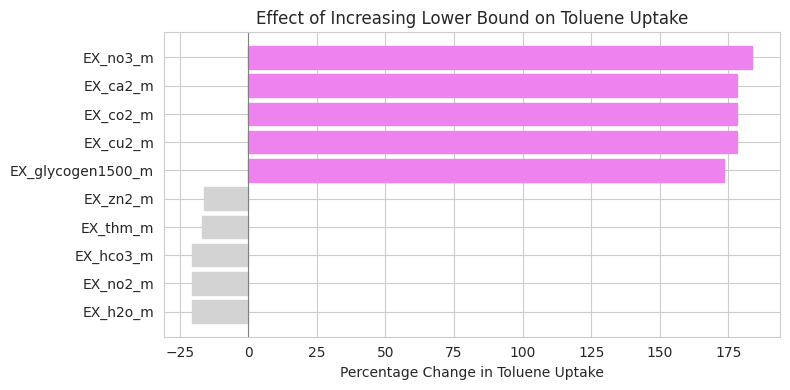

In [33]:
import matplotlib.pyplot as plt

data = toluene_uptake_by_effector
baseline_flux = data.pop('baseline')
percentage_change = {k: ((v - baseline_flux) / baseline_flux * 100) for k, v in data.items()}
percentage_change = {k: v for k, v in percentage_change.items() if abs(v) > 15}
items_sorted = sorted(percentage_change.items(), key=lambda x: x[1])
labels = [k for k, _ in items_sorted]
values = [v for _, v in items_sorted]

# Creating the plot
plt.figure(figsize=(8, 4))
bars = plt.barh(labels, values, color='skyblue')
plt.xlabel('Percentage Change in Toluene Uptake')
plt.title('Effect of Increasing Lower Bound on Toluene Uptake')
plt.axvline(0, color='grey', linewidth=0.8)

for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('lightgray')
    else:
        bar.set_color('violet')

plt.tight_layout()
plt.show()

## Increasing Toluene Uptake Through Biostimulation

From the plot above, it looks like `Nitrate` (NO3), `Calcium` (Ca2), and `Copper` (Cu2) are good candidate nutrients to enhance toluene degradation. These nutrients would be easy to add to the environment as a biostimulation strategy, and their addition could potentially enhance the community's bioremediation potential.

However, the potential side effects on the ecosystem must be cautiously weighed. The introduction of these nutrients might influence other ecological processes and organisms. Thus, biostimulation strategies require careful planning and monitoring to ensure they are effective and do not inadvertently cause harm.

Having identified nutrients that could boost toluene bioremediation, we're now set to devise a biostimulation strategy to enhance _Pseudomonas_'s toluene uptake. We'll focus on increasing the uptake rate of the three candidate nutrients to simulate an addition of these nutrients to the environment. By simulating community growth in this nutrient-enriched medium, we can compare the toluene uptake rates against those from the baseline scenario.

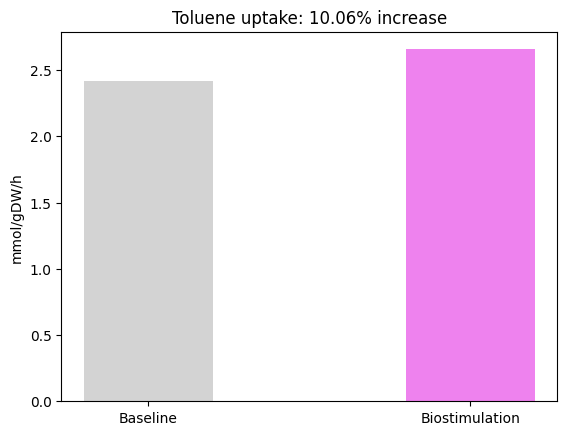

In [5]:
import matplotlib.pyplot as plt

percent_increase = 50
selected_effectors = ["EX_no3_m", "EX_ca2_m", "EX_cu2_m"]

# Reset medium
cgem.medium = medium.set_index('reaction').squeeze()
sol = cgem.cooperative_tradeoff(fraction=0.5, fluxes=True)

toluene_uptake = cgem.reactions.get_by_id('EX_tol_m')
old_toluene_uptake_rate = sol.fluxes.loc['medium','EX_tol_m']

# Increase uptake rate of selected nutrients
selected_nutrients = selected_effectors
for rxn_id in selected_nutrients:
    old_uptake_bound = cgem.reactions.get_by_id(rxn_id).lower_bound
    cgem.reactions.get_by_id(rxn_id).lower_bound = (1 + percent_increase/100) * old_uptake_bound

# Update optimization
sol = cgem.cooperative_tradeoff(fraction=0.5, fluxes=True)
new_toluene_uptake_rate = sol.fluxes.loc['medium','EX_tol_m']

# Plot uptake changes
pct_change = round((new_toluene_uptake_rate - old_toluene_uptake_rate) / old_toluene_uptake_rate * 100, 2)
plt.bar(['Baseline', 'Biostimulation'], [-old_toluene_uptake_rate, -new_toluene_uptake_rate], width=0.4, color=['lightgray', 'violet'])
plt.ylabel('mmol/gDW/h')
plt.title(f'Toluene uptake: {pct_change}% increase')
plt.show()

After the simulated biostimulation strategy, toluene uptake has increased significantly compared to the baseline scenario. This is an impressive increase. While only a simulation which would require experimental validation at this point, it shows that community models can be instrumental in designing biostimulation strategies to enhance bioremediation of oil spills by increasing the uptake of toxic compounds by microbial communities.

## Conclusions

In this notebook, we've utilized a community genome-scale metabolic model to explore the trophic network formed after a marine coastal oil spill. Employing constraint-based modeling techniques such as Flux Balance Analysis (FBA) and the calculation of nutrient effects on uptake rates, we've identified environmental nutrients that could potentially enhance the degradation of toxic compounds. Leveraging this knowledge, we've developed a biostimulation strategy, adding specific nutrients to the medium to boost the community's bioremediation potential.